In [1]:
#Insert description for CDC paper here

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn

In [2]:
#to reproduce paper results
np.random.seed(4)
torch.manual_seed(25) #not clear if this works in jupyter

In [3]:
#global variables
x_bar = 1.0   #maximum consumption
noise_var = 1.0    #variance of noise values
g = np.arange(0,1.1,0.1)  #discretization of space of power consumption values x \in [0,\bar{x}]
s_vals = np.arange(-2.0,2.0,0.1)  #discretization of space of noise values, 98% of normal distribution with unit variance
samples = np.random.normal(0, noise_var, size=100000)
s_hist = np.histogram(samples, bins=np.arange(-2.0,2.1,0.1), normed=True)[0]
s_hist = (1.0/np.linalg.norm(s_hist, ord=1)) * s_hist #probabilities over discretized noise values
ramp_const = 0.3  #time coupling ramping constraint
pi_cp_perc = 0.6  #ratio of pi_cp cost to total utility under a naive fixed strategy

net_params = {'FEATURE_DIM': 4, 'OUTPUT_DIM': 1, 'HIDDEN_1': 16}

base_path = "/home/chase/projects/peakload/notebooks/" #change this to path to notebook + data

In [4]:
#Function definitions

In [14]:
#basic functions

def prob_t_is_max(max_so_far, t, T):
    #conditionally independent probability that next iid sample of noise will be max over T
    coeff = 1.0/(T - t)
    prod = (1.0 - np.power(norm.cdf(max_so_far), T-t))
    return(coeff*prod)

def prob_any_next_t_is_max(max_so_far, t, T):
    #probability that any next T-t samples will be maximum over sequence of length T
    prod = (1.0 - np.power(norm.cdf(max_so_far), T-t))
    return(prod)

def log_utility(x):
    #example utility function, continuously differentiable, monotonically increasing first derivative
    #this example exhibits a diminishing return on increased power consumption x 
    y = 2.0*np.log(1 + np.power(x,1/2))
    return(np.sum(y))

def log_utility_opt_x(T, pi_cp):
    frac = (2*T)/pi_cp
    x_1 = frac + np.sqrt((frac - 1)*(frac + 1))
    x_2 = frac - np.sqrt((frac - 1)*(frac + 1))
    return((x_1, x_2))

def log_utility_opt_x_single_t(pi_cp):
    frac = (2)/pi_cp
    x_1 = frac + np.sqrt((frac - 1)*(frac + 1))
    x_2 = frac - np.sqrt((frac - 1)*(frac + 1))
    return((x_1, x_2))

def batch_data_arrays(data, labels, batchsize, sampledim = 1):
    #creates mini-batches and converts to Torch tensors for training
    remainder = data.shape[sampledim] % batchsize
    diff = batchsize - remainder
    tail = data[0,-diff:]
    out = [ (torch.Tensor(data[:,i*batchsize:(i+1)*batchsize].T), torch.Tensor(labels[i*batchsize:(i+1)*batchsize])) for i in range(int(float(data.shape[sampledim])/float(batchsize))) ]
    return(out)

def poly_utility(x, a=1.386):
    y = a*np.power(x, 1/4)
    return(np.sum(y))

def poly_utility_opt_x(T, pi_cp, a=1.386): #naive opt x
    num = T*a
    denom = 4*pi_cp
    opt_x = np.power(num/denom, 4/3)
    if opt_x > x_bar:
        ret = x_bar
    elif opt_x < 0:
        ret = 0
    return(opt_x)
        

In [9]:
seaborn.set()

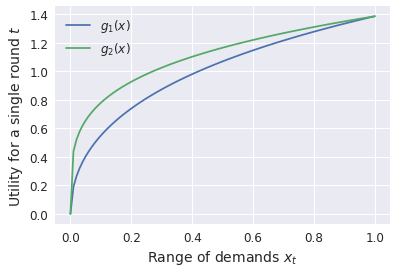

In [88]:
#plt.plot(np.arange(0,1.01,0.01), 1.386*np.arange(0,1.01,0.01), label='$g_{1}(x)$')
plt.plot(np.arange(0,1.01,0.01), 2.0*np.log(1 + np.power(np.arange(0,1.01,0.01), 1/2)), label='$g_{1}(x)$')
plt.plot(np.arange(0,1.01,0.01), 1.386*np.power(np.arange(0,1.01,0.01),1/4), label='$g_{2}(x)$')
plt.legend(fontsize=12)
plt.xlabel("Range of demands $x_{t}$", fontsize=14)
plt.ylabel("Utility for a single round $t$", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

In [11]:
#Neural network class definition and training helper function
#This neural network learns an approximate deterministic policy

class nnet(nn.Module):
    #a linear neural network with a sigmoid activiation function and a single hidden layer
    def __init__(self, params):
        super(nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.H1 = params['HIDDEN_1']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.H1)
        self.l2 = nn.Linear(self.H1, self.D_out)
    
    def forward(self, x):
        x = torch.sigmoid(self.l1(x)) #sigmoid activation
        x = self.l2(x) #hidden layer
        return(x)
    
    
def train(net_obj, loss_func, opt_func, trainX, trainY, valX, valY, batchsize=100, epochs=50, verbose=True):
    print("Training")
    train_batches = batch_data_arrays(trainX, trainY, batchsize)
    num_batches = len(train_batches)
    
    train_epoch_loss = []
    val_epoch_loss = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        #iterate over minibatches
        for i, data in enumerate(train_batches):
            inputs, labels = data[0], data[1].unsqueeze(1)
            
            #make Variable
            inputs, labels = Variable(inputs), Variable(labels) 
            #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            
            #zero gradient
            opt_func.zero_grad()
            
            #compute training loss
            outputs = net_obj(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            opt_func.step()
            
            running_loss += 0.0
        
        #compute validation loss
        train_epoch_loss.append(running_loss)
        val_out = net_obj(torch.Tensor(valX.T))
        val_loss = loss_func(val_out, torch.Tensor(valY).unsqueeze(1))
        val_epoch_loss.append(val_loss)
        
        #output progress
        if verbose==True:
            print("==epoch " + str(epoch) + "==")
            print("training loss: " + str(running_loss))
            print("validation loss: " + str(val_loss))
        
    #neural network object updated inplace, return loss over epochs
    return(train_epoch_loss, val_epoch_loss)

In [12]:
#Monte Carlo path sampling

In [15]:
def simulate_step(x_prev):
    g_const = g[(g >= x_prev - ramp_const) & (g <= x_prev + ramp_const)]
    x_next = np.random.choice(g_const)
    s_next = np.random.choice(s_vals, p=s_hist)
    return(x_next, s_next)

def generate_sample_paths(T, util_func=log_utility, N=1000, sim_MC=100):
    #T is the total depth of simulations
    #N is the total number of sample paths to simulate
    #sim_MC is the number of Monte Carlo iterations per simulation
    
    samples_per_t = int(float(N)/float(T-1)) #divide sample paths amongst 
                                           #equal number of initial times t = [1,..., T]
        
    X = np.zeros((4,N))
    Y = np.zeros((N,))
    
    ind = np.arange(0, N, 1) #index for data matrix
    
    #pi_cp rate for T
    pi_cp = pi_cp_perc*T*util_func(x_bar)
    
    for t in range(T-1):
        #for each initial t
        rounds_left = T-(t+1)
        for i in list(ind[t*samples_per_t:(t+1)*samples_per_t]):
            #populate features for sample path
            #sample initial value
            x_1 = np.random.choice(g)
            X[0,i] = x_1 #previous state
            
            s_m = 0.0
            for m in range(t):
                s_m = np.max([ s_m, np.random.choice(s_vals, p=s_hist) ])
            X[1,i] = s_m #maximum noise seen so far, previous values don't matter since less than this
            
            X[2,i] = float(rounds_left)/float(T) #normalized number of rounds left to go
            
            X[3,i] = np.random.uniform(0,1) #initialize linear bias weight
            
            #forward simulate for all possible next choices
            sim_rewards = {}
            
            for x_2_i in range(g.shape[0]):
                x_2 = g[x_2_i]
                if np.abs(x_2 - x_1) > ramp_const:
                    pass
                else:
                    #go forward for T-t
                    sim_rewards[x_2] = []
                    for s in range(sim_MC):
                        #initialize simulated path
                        s_2 = np.random.choice(s_vals, p=s_hist)
                        plays = [x_1, x_2]
                        noises = [s_m, s_2]
                        x_iter = x_2
                        for r in range(rounds_left):
                            x_iter, s_iter = simulate_step(x_iter)
                            plays.append(x_iter)
                            noises.append(s_iter)
                            
                        sim_reward = util_func(np.array(plays)) - pi_cp*plays[np.argmax(noises)]
                        sim_rewards[x_2].append(sim_reward)
            
            best_x_2 = 0
            best_expected_reward = 0.0
            for x_2 in sim_rewards:
                if np.mean(sim_rewards[x_2]) > best_expected_reward:
                    best_x_2 = x_2
                    best_expected_reward = np.mean(sim_rewards[x_2])
                    
            Y[i] = best_x_2
            
    return(X,Y)

In [48]:
pi_cp

8.315999999999999

0.3112086629553587
0.0
6.962450767138238
7.605540626973209
7.762747670263073
7.696052300711321
7.496824315416484
7.208748671956431
6.856420298509705
6.455178700784016
6.015291925454612
5.5440000000000005


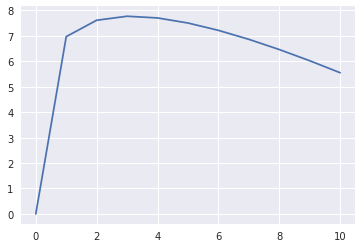

In [51]:
#test is naive_optimal_poly is working
x_in= np.arange(0,1.1,0.1)
T = 10
pi_cp = pi_cp_perc*T*poly_utility(x_bar)
sol = poly_utility_opt_x(T, pi_cp)
print(sol)
allo = []
for a in x_in:
    print(T*poly_utility(a) - pi_cp*a)
    allo.append(T*poly_utility(a) - pi_cp*a)
    
plt.plot(allo)
plt.show()

In [50]:
x_in

array([0., 1.])

In [41]:
#evaluation routine

def naive_optimal_utility(T):
    pi_cp = pi_cp_perc*T*log_utility(x_bar)
    sol1, sol2 = log_utility_opt_x(T, pi_cp)
    nopt_reward = T*log_utility(sol2) - pi_cp*sol2
    return(nopt_reward, (sol1, sol2))

def naive_optimal_poly(T):
    pi_cp = pi_cp_perc*T*poly_utility(x_bar)
    sol = poly_utility_opt_x(T, pi_cp)
    nopt_reward = T*poly_utility(sol) - pi_cp*sol
    return(nopt_reward, (sol))
    
def evaluate_net(net_obj, util_func, T, pi_cp, naive_opt_reward, x_1=0.7, trials=100):
    winloss = []
    rewards = []
    plays_all = []
    for i in range(trials):
        noises = []
        plays = []
        x_curr = x_1
        for j in range(T): #includes initial round noise sample
            t = j+1
            s_t = np.random.choice(s_vals, p=s_hist)
            noises.append(s_t)
            
            s_m = np.max(noises) #max so far
            
            inputvec = torch.Tensor(np.array([x_curr, s_m, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)
            
            play_output = net_obj(inputvec)
            play = float(play_output.data[0,0])
            
            #snap to nearest value in range
            if play > x_bar: play = x_bar
            if play < 0.0: play = 0.0
                
            #snap to nearest feasible value if constraints violated
            if np.abs(x_curr - play) > ramp_const:
                if play > x_curr: play = x_curr + ramp_const
                if play < x_curr: play = x_curr - ramp_const
                    
            #attach previous play
            plays.append(x_curr)
            x_curr = play
        
        reward = util_func(np.array(plays)) - pi_cp*plays[np.argmax(noises)]
        rewards.append(reward)
        
        if reward > naive_opt_reward: winloss.append(1)
        else: winloss.append(0)
            
        plays_all.append(plays)
            
    return(np.mean(winloss), np.mean(rewards), plays_all)
    

In [ ]:
#train networks
for T in range(2,16):
#for T in range(11,50):
#for T in [16, 21, 25]:
    print("Simulating: T=" + str(T) + "...")
    if T in [8, 11, 12, 16, 21, 25]:
        X, Y = generate_sample_paths(T, N=T*500, sim_MC=200) #T=8, 11, 12, 21, 25 does significantly better with less samples, haven't optimized hyperparameters
    else:
        X, Y = generate_sample_paths(T, N=T*1000, sim_MC=100) #increase number of samples per increase in T
    
    #train/val split
    train_X = X[:,0:int(0.8*X.shape[1])]
    train_Y = Y[0:int(0.8*Y.shape[0])]
    val_X = X[:,int(0.8*X.shape[1]):]
    val_Y = Y[int(0.8*Y.shape[0]):]
    
    #instantiate network
    net = nnet(net_params)#.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    
    #train
    train_loss, val_loss = train(net, criterion, optimizer, train_X, train_Y, val_X, val_Y, batchsize=100, epochs=500, verbose=False)
    
    #save the network
    path = "/home/chase/projects/peakload/notebooks/cdc_19/nets/"
    torch.save(net.state_dict(), path + "T" + str(T) + "_logutil.torch")
    
    del(net) #ensure reference is empty because python weird like that
    print("==============\n")

In [93]:
#train networks
for T in range(2,11):
#for T in range(10,11):
    print("Simulating: T=" + str(T) + "...")
    X, Y = generate_sample_paths(T, poly_utility, N=T*500, sim_MC=100)
    
    #train/val split
    train_X = X[:,0:int(0.8*X.shape[1])]
    train_Y = Y[0:int(0.8*Y.shape[0])]
    val_X = X[:,int(0.8*X.shape[1]):]
    val_Y = Y[int(0.8*Y.shape[0]):]
    
    #instantiate network
    net = nnet(net_params)#.cuda()
    try:
        net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + "_polyutil_ex.torch")) #train further
    except:
        net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + "_polyutil.torch")) #train further
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    
    #train
    train_loss, val_loss = train(net, criterion, optimizer, train_X, train_Y, val_X, val_Y, batchsize=200, epochs=500, verbose=False)
    
    #save the network
    path = "/home/chase/projects/peakload/notebooks/cdc_19/nets/"
    torch.save(net.state_dict(), path + "T" + str(T) + "_polyutil_ex.torch")
    
    del(net) #ensure reference is empty because python weird like that
    print("==============\n")

Simulating: T=2...
Training

Simulating: T=3...
Training

Simulating: T=4...
Training

Simulating: T=5...
Training

Simulating: T=6...
Training

Simulating: T=7...
Training

Simulating: T=8...
Training

Simulating: T=9...
Training

Simulating: T=10...
Training



In [ ]:
###############evaluating logarithmic utility function

In [75]:
#plot for increasing T the gap between naive optimal and forward-simulated trained policy expected rewards

win_loss_percs = []
net_rewards = []
naive_opt_rewards = []
pk_rewards = []

for T in range(2,16):
    #load the network
    net = nnet(net_params)
    net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + ".torch"))
    net.eval()
    
    #evaluate
    print("Evaluating " + str(T) + "...")
    pi_cp = pi_cp_perc*T*log_utility(x_bar)
    nopt_reward, nopt = naive_optimal_utility(T)
    naive_opt_rewards.append(nopt_reward)
    print(nopt)
    
    #perfect reward
    pk_noise_play = np.min([x_bar, np.max(log_utility_opt_x_single_t(pi_cp))])
    if np.isnan(pk_noise_play):
        pk_noise_play = 0
    if pk_noise_play < 0:
        pk_noise_play = 0
    if T == 2:
        pk_noise_play = 0
    pk_rewards.append((T-1)*log_utility(x_bar) + log_utility(pk_noise_play) - pi_cp*pk_noise_play)
    
    net.eval() #set network to evaluation mode (not neccessary for this particular architecture but no harm in including)
    win_loss, policy_reward, nnplays = evaluate_net(net, log_utility, T, pi_cp, nopt_reward, x_1=0.5)  #double check where to start from
    net_rewards.append(policy_reward)
    win_loss_percs.append(win_loss)
    
del(net)

Evaluating 2...
(4.591174268424552, 0.2178092012053261)
Evaluating 3...
(4.5911742684245525, 0.2178092012053261)
Evaluating 4...
(4.591174268424552, 0.2178092012053261)
Evaluating 5...
(4.5911742684245525, 0.2178092012053261)
Evaluating 6...
(4.5911742684245525, 0.2178092012053261)


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in sqrt


Evaluating 7...
(4.5911742684245525, 0.2178092012053261)
Evaluating 8...
(4.591174268424552, 0.2178092012053261)
Evaluating 9...
(4.5911742684245525, 0.2178092012053261)
Evaluating 10...
(4.5911742684245525, 0.2178092012053261)
Evaluating 11...
(4.5911742684245525, 0.2178092012053261)
Evaluating 12...
(4.5911742684245525, 0.2178092012053261)
Evaluating 13...
(4.5911742684245525, 0.2178092012053261)
Evaluating 14...
(4.5911742684245525, 0.2178092012053261)
Evaluating 15...
(4.591174268424552, 0.2178092012053261)


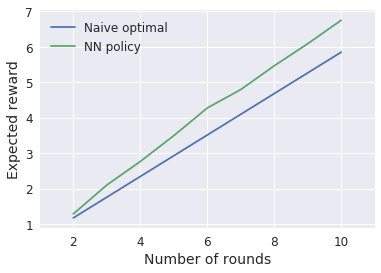

In [79]:
T_range = np.arange(2,11,1)
plt.plot(T_range, naive_opt_rewards[0:9], label="Naive optimal")
plt.plot(T_range, net_rewards[0:9], label="NN policy")
#plt.plot(T_range, np.log(pk_rewards), label="Perfect knowledge")
plt.ylabel("Expected reward", fontsize=14)
plt.xlabel("Number of rounds", fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.xlim(1,11)
plt.show()

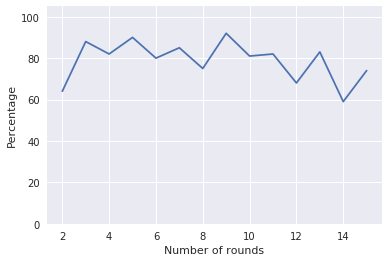

In [18]:
plt.plot(T_range, 100*np.array(win_loss_percs))
plt.ylabel("Percentage")
plt.xlabel("Number of rounds")
plt.ylim(0,105)
plt.show()

In [ ]:
#plot of policy for T = 2
x_curr_i = 3
x_curr = g[x_curr_i]
g_const = g[(g <= g[x_curr_i] + ramp_const) & (g >= g[x_curr_i] - ramp_const)]
T = 4

policies = []

for t in [1,2,3]:
    net = nnet(net_params)
    try:
        net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + "_ex.torch"))
    except:
        net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + ".torch"))
    net.eval()

    policy = []
    for s in s_vals:
        inputvec = torch.Tensor(np.array([x_curr, s, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)

        play_output = net(inputvec)
        play = float(play_output.data[0,0])

        #snap to nearest value in range
        if play > x_bar: play = x_bar
        if play < 0.0: play = 0.0

        #snap to nearest feasible value if constraints violated
        if np.abs(x_curr - play) > ramp_const:
            if play > x_curr: play = x_curr + ramp_const
            if play < x_curr: play = x_curr - ramp_const

        policy.append(play)
    policies.append(policy)
    
del(net)

In [ ]:
for t in range(3):
    plt.plot(s_vals, np.asarray(policies[t]), label="t = " + str(t+1))
plt.legend(fontsize=12)
plt.ylabel("Value of $x_{t+1}$ to play", fontsize=14)
plt.xlabel("Maximum observed noise thus far: $s_m$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Policies for varying t, $x_1 = 0.3$, T = 4", fontsize=14)
plt.show()

In [ ]:
#############polynomial utility function############3

In [94]:
#plot for increasing T the gap between naive optimal and forward-simulated trained policy expected rewards

win_loss_percs = []
net_rewards = []
naive_opt_rewards = []
pk_rewards = []

for T in range(2,16):
    #load the network
    net = nnet(net_params)
    try:
        net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + "_polyutil_ex.torch"))
    except:
        net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + "_polyutil.torch"))
    net.eval()
    
    #evaluate
    print("Evaluating " + str(T) + "...")
    pi_cp = pi_cp_perc*T*poly_utility(x_bar)
    nopt_reward, nopt = naive_optimal_poly(T)
    naive_opt_rewards.append(nopt_reward)
    
    net.eval() #set network to evaluation mode (not neccessary for this particular architecture but no harm in including)
    win_loss, policy_reward, nnplays = evaluate_net(net, poly_utility, T, pi_cp, nopt_reward, x_1=0.4)  #double check where to start from
    net_rewards.append(policy_reward)
    win_loss_percs.append(win_loss)
    
del(net)

Evaluating 2...
Evaluating 3...
Evaluating 4...
Evaluating 5...
Evaluating 6...
Evaluating 7...
Evaluating 8...
Evaluating 9...
Evaluating 10...
Evaluating 11...
Evaluating 12...
Evaluating 13...
Evaluating 14...
Evaluating 15...


In [95]:
nopt

0.3112086629553587

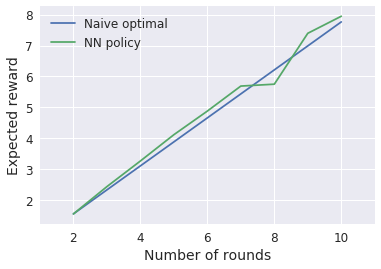

In [96]:
T_range = np.arange(2,11,1)
plt.plot(T_range, naive_opt_rewards[0:9], label="Naive optimal")
plt.plot(T_range, net_rewards[0:9], label="NN policy")
#plt.plot(T_range, np.log(pk_rewards), label="Perfect knowledge")
plt.ylabel("Expected reward", fontsize=14)
plt.xlabel("Number of rounds", fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.xlim(1,11)
plt.show()

In [85]:
#plot of policy for T = 2
x_curr_i = 3
x_curr = g[x_curr_i]
g_const = g[(g <= g[x_curr_i] + ramp_const) & (g >= g[x_curr_i] - ramp_const)]
T = 4

policies = []

for t in [1,2,3]:
    net = nnet(net_params)
    net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + "_polyutil.torch"))
    net.eval()

    policy = []
    for s in s_vals:
        inputvec = torch.Tensor(np.array([x_curr, s, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)

        play_output = net(inputvec)
        play = float(play_output.data[0,0])

        #snap to nearest value in range
        if play > x_bar: play = x_bar
        if play < 0.0: play = 0.0

        #snap to nearest feasible value if constraints violated
        if np.abs(x_curr - play) > ramp_const:
            if play > x_curr: play = x_curr + ramp_const
            if play < x_curr: play = x_curr - ramp_const

        policy.append(play)
    policies.append(policy)
    
del(net)

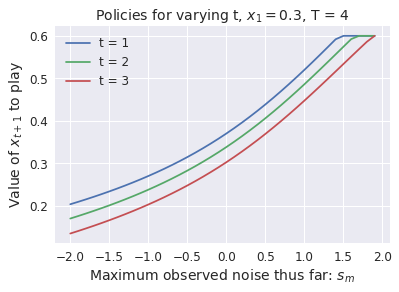

In [86]:
for t in range(3):
    plt.plot(s_vals, np.asarray(policies[t]), label="t = " + str(t+1))
plt.legend(fontsize=12)
plt.ylabel("Value of $x_{t+1}$ to play", fontsize=14)
plt.xlabel("Maximum observed noise thus far: $s_m$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Policies for varying t, $x_1 = 0.3$, T = 4", fontsize=14)
plt.show()

In [17]:

def grid_search_optimal(x_1_i, noise_sequence, grid):
    #returns the optimal plays iterating on a sequence of observed noise values
    #grid_search = np.load(grid_search_file_path)
    T = len(noise_sequence)
    x_curr = x_1_i
    outcomes = grid
    plays = [g[x_1_i]]
    for t in range(T-1):
        #T = 2 has shape (11, 40, 11), last is t=0
        #T= 3 has shape (11, 40, 11, 40, 11), last is t=1
        #T = 4 has shape (11, 40, 11, 40, 11, 40, 11), last is t=2
        s_curr = noise_sequence[t]
        best_reward = 0
        best_x_2_i = 0
        outcomes = outcomes[x_curr, s_curr]
        if t == T-2:
            best_x_2_i = np.argmax(outcomes)
            expected_reward = np.max(outcomes)
        else:
            g_const_i = np.arange(0,11,1)[(g <= g[x_curr] + ramp_const) & (g >= g[x_curr] - ramp_const)]
            for x_i in g_const_i:
                forward = outcomes[g_const_i]
                expected_reward = np.mean(forward[forward > 0.0])
                if expected_reward > best_reward:
                    best_reward = expected_reward
                    best_x_2_i = x_i
        plays.append(g[best_x_2_i])
        x_curr = best_x_2_i
    return(plays, expected_reward)

In [93]:
#bar plot of T = 2, 3, 4 difference between forward-simulated trained policy and grid optimal expected rewards
base_path = "/home/chase/projects/peakload/notebooks/"

nn_rewards = []
grid_rewards = []
grid_exp_rewards = {}
pk_rewards = []
naive_opt_rewards = []
win_loss_percs = []

for T in [2,3,4]:
    print(T)
    grid_exp_rewards[T] = []
    mc_nn_r = []
    mc_gs_r = []
    
    pi_cp = pi_cp_perc*T*log_utility(x_bar)
    
    #load grid
    grid_opt = np.load(base_path + "t" + str(T) + "_grid_search.txt")
    print(grid_opt.shape)

    for mc in range(100):

        #realize sequences of noises
        s_i = [np.random.choice(np.arange(0,40,1), p=s_hist) for i in range(T)] #, p=s_hist
        s = [ s_vals[j] for j in s_i ]

        #grid_opt_path
        grid_plays, exp_reward = grid_search_optimal(7, s_i, grid_opt)

        #noises = []
        #plays = []
        #x_curr = 0.5
        #for j in range(T):
        #    t = j+1
        # 
        #    s_t = s[j]
        #    noises.append(s_t)
        #    s_m = np.max(noises)
        #
        #    inputvec = torch.Tensor(np.array([x_curr, s_m, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)
        #
        #    play_output = net(inputvec)
        #    play = float(play_output.data[0,0])
        #
        #    #snap to nearest value in range
        #    if play > x_bar: play = x_bar
        #    if play < 0.0: play = 0.0
        # 
        #    #snap to nearest feasible value if constraints violated
        #    if np.abs(x_curr - play) > ramp_const:
        #        if play > x_curr: play = x_curr + ramp_const
        #        if play < x_curr: play = x_curr - ramp_const

            #attach previous play
        #    plays.append(x_curr)
        #    x_curr = play

        #nn_reward = log_utility(np.array(plays)) - pi_cp*plays[np.argmax(s)]
        grid_reward = log_utility(np.array(np.array(grid_plays) + 0.08)) - pi_cp*grid_plays[np.argmax(s)] #best case subject to grid search resolution
        grid_exp_rewards[T].append(exp_reward)

        #mc_nn_r.append(nn_reward)
        mc_gs_r.append(grid_reward)
    
    grid_rewards.append(np.mean(mc_gs_r))
    mc_grd_reward = np.mean(mc_gs_r)
    
    #load nn

    net = nnet(net_params)
    net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + ".torch"))
    net.eval()

    win_loss, policy_reward, nn_plays = evaluate_net(net, T, pi_cp, mc_grd_reward, x_1=0.5)  #double check where to start from
    nn_rewards.append(policy_reward)
    win_loss_percs.append(win_loss)   
    del(net)
        
    pk_noise_play = np.min([x_bar, np.max(log_utility_opt_x_single_t(pi_cp))])
    if np.isnan(pk_noise_play):
        pk_noise_play = 0
    if pk_noise_play < 0:
        pk_noise_play = 0
    if T == 2:
        pk_noise_play = 0
    pk_rewards.append((T-1)*log_utility(x_bar) + log_utility(pk_noise_play) - pi_cp*pk_noise_play)
    
    nopt_reward = naive_optimal_utility(T)[0]
    naive_opt_rewards.append(nopt_reward)
    



2
(11, 40, 11)
3
(11, 40, 11, 40, 11)
4


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in sqrt


(11, 40, 11, 40, 11, 40, 11)


In [85]:
ger = [np.mean(grid_exp_rewards[2]) , np.mean(grid_exp_rewards[3]) , np.mean(grid_exp_rewards[4]) ]
print(ger)

[1.3486254224997694, 2.041055940984963, 2.6779721716114646]


In [86]:
nn_rewards

[1.2858494632073114, 2.0538843623391956, 2.7568131037826067]

In [87]:
grid_rewards

[1.4514056614778799, 2.241398668751619, 3.00440504233256]

In [88]:
pk_rewards

[1.3862943611198906, 2.772588722239781, 4.1588830833596715]

In [89]:
naive_opt_rewards

[1.1697236254452936, 1.7545854381679407, 2.3394472508905872]

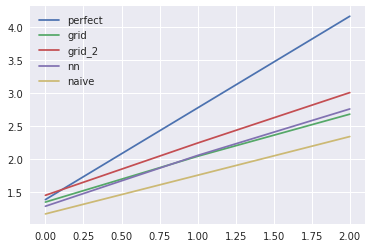

In [90]:
plt.plot(pk_rewards, label="perfect")
plt.plot(ger, label="grid")
plt.plot(grid_rewards, label="grid_2")
plt.plot(nn_rewards, label="nn")
plt.plot(naive_opt_rewards, label="naive")
plt.legend()

plt.show()

In [91]:
fig, ax = plt.subplots()

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Testing'

ax.set_xticklabels(labels)

[Text(0,0,'0.0'),
 Text(0.2,0,'Testing'),
 Text(0.4,0,'0.4'),
 Text(0.6,0,'0.6'),
 Text(0.8,0,'0.8'),
 Text(1,0,'1.0')]

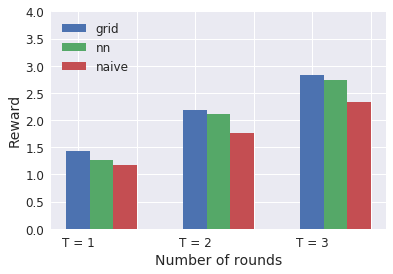

In [95]:
pos = np.arange(0,3,1)
seaborn.set()


fig, ax = plt.subplots()
fig.canvas.draw()

#plt.bar(pos-0.2, pk_rewards, label="perfect", width=0.2)
plt.bar(pos, grid_rewards, label="grid", width=0.2)
plt.bar(pos+0.2, nn_rewards, label="nn", width=0.2)
plt.bar(pos+0.4, naive_opt_rewards, label="naive", width=0.2)
#plt.bar(np.arnage(4,29,5), np.zeros((3,)), width=1)
plt.legend(loc=2, fontsize=12)
plt.ylim(0,4)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ["", "T = 1", "", "T = 2", "", "T = 3", ""]
ax.set_xticklabels(labels)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Number of rounds", fontsize=14)



plt.show()

array([ 0,  5, 10, 15, 20])

In [ ]:
for mc in range(100):

        #realize sequences of noises
        s_i = [np.random.choice(np.arange(0,40,1), p=s_hist) for i in range(T)]
        s = [ s_vals[j] for j in s_i ]

        #grid_opt_path
        grid_plays = grid_search_optimal(3, s_i, grid_opt)

        noises = []
        plays = []
        x_curr = 0.5
        for j in range(T):
            t = j+1
     
            s_t = s[j]
            noises.append(s_t)
            s_m = np.max(noises)

            inputvec = torch.Tensor(np.array([x_curr, s_m, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)

            play_output = net(inputvec)
            play = float(play_output.data[0,0])

            #snap to nearest value in range
            if play > x_bar: play = x_bar
            if play < 0.0: play = 0.0

            #snap to nearest feasible value if constraints violated
            if np.abs(x_curr - play) > ramp_const:
                if play > x_curr: play = x_curr + ramp_const
                if play < x_curr: play = x_curr - ramp_const

            #attach previous play
            plays.append(x_curr)
            x_curr = play